In [1]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 25.9MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# Data

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/X_train_n1')
X_train2 = torch.load('/content/drive/My Drive/data_audio/X_train_n2')
X_train3 = torch.load('/content/drive/My Drive/data_audio/X_train_n3')
X_train4 = torch.load('/content/drive/My Drive/data_audio/X_train_n4')
y_train1 = torch.load('/content/drive/My Drive/data_audio/y_train_n1')
y_train2 = torch.load('/content/drive/My Drive/data_audio/y_train_n2')
y_train3 = torch.load('/content/drive/My Drive/data_audio/y_train_n3')
y_train4 = torch.load('/content/drive/My Drive/data_audio/y_train_n4')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([20000, 1, 128, 340])
torch.Size([20000, 1, 128, 340])


# Model

In [2]:
class LSTMDNN(nn.Module):
    """
    LSTM based dereverberation
    """

    def __init__(self):
        super(LSTMDNN, self).__init__()
        self.lstm1 = nn.LSTM(128*11, 512)
        self.lstm2 = nn.LSTM(512, 512)
        self.linear = nn.Linear(512, 128)

        
    def forward(self, x):
        x, _ = self.lstm1(x.view(x.shape[0], 1, x.shape[1]))
        x, _ = self.lstm2(x)
        x = self.linear(x[:, 0, :])
        return x

In [12]:
def generate_spec(audio_sequence, rate, n_fft=2048, hop_length=512):
  """
  generate spectrogram using Librosa

  audio_sequence: list containing waveform
  rate: sampling rate
  n_fft, hop_length: stft parameters

  return log power spectra
  """
  S = librosa.feature.melspectrogram(audio_sequence, sr=rate, n_fft=n_fft, hop_length=hop_length, n_mels=128, fmin=20, fmax=8300)
  log_spectra = librosa.power_to_db(S, ref=np.mean, top_db=80)
  return log_spectra

def split_specgram(example, clean_example, frames = 11):
  """
  Split specgram in groups of frames, the purpose is prepare data for the LSTM model input

  example: reverberant spectrogram
  clean_example: clean or target spectrogram

  return data input to the LSTM model and targets
  """
  clean_spec = clean_example[0, :, :]
  rev_spec = example[0, :, :]

  n, m = clean_spec.shape

  targets = torch.zeros((m-frames, n))
  data = torch.zeros((m-frames, n*frames))

  for i in range(m-frames):
    targets[i, :] = clean_spec[:, i]
    data[i, :] = torch.reshape(rev_spec[:, i:i+frames], (1, -1))[0, :]
  return data, targets


def split_realdata(example, frames = 11):

  """
  Split 1 specgram in groups of frames, the purpose is prepare data for the LSTM model input

  example: reverberant ''real'' (not simulated) spectrogram

  return data input to the LSTM model 
  """
  
  rev_spec = example[0, :, :]
  n, m = rev_spec.shape
  data = torch.zeros((m-frames, n*frames))
  for i in range(m-frames):
    data[i, :] = torch.reshape(rev_spec[:, i:i+frames], (1, -1))[0, :]
  return data

def prepare_data(X, y, display = False):
  """
  Use split_specgram to split all specgrams
  X: tensor containing reverberant spectrograms
  y: tensor containing tensor spectrograms
  """

  data0, target0 = split_specgram(X[0, :, :, :], y[0, :, :, :])

  total_data = data0.cuda()
  targets = target0.cuda()
  
  for i in range(1, X.shape[0]):
    
    if display: 
      print("Specgram n°" + str(i)) 
      
    data_i, target_i = split_specgram(X[i, :, :, :], y[i, :, :, :])
    
    total_data = torch.cat((total_data, data_i.cuda()), 0)
    targets = torch.cat((targets, target_i.cuda()), 0)

  return  total_data, targets

def graph_spec(spec, rate = 16000, title = False):
  """
  plot spectrogram 
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """

  plt.figure()
  display.specshow(spec, sr=rate, y_axis='mel', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  if (title):
    plt.title('Log-Power spectrogram')
  plt.tight_layout()

def reconstruct_wave(spec, rate = 16000):
  """
  Reconstruct waveform
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """
  power = librosa.db_to_power(spec, ref = 5.0)
  audio = librosa.feature.inverse.mel_to_audio(power, sr = rate, n_fft = 2048, hop_length = 512)
  return audio

def plot_time_wave(spec, rate = 16000):
  """
  plot waveform given spectrogram
  spec: spectrogram generated using librosa
  rate: sampling rate
  
  """
  audio = reconstruct_wave(spec) 
  time = [0]
  for i in range(1, len(audio)):
    time.append(time[i-1] + 1/rate)

  plt.figure()
  plt.plot(time, audio)
  plt.xlabel("Time (secs)")
  plt.ylabel("Power")

def normalize(spec, eps=1e-6):
  """
  Normalize spectrogram with zero mean and unitary variance
  spec: spectrogram generated using Librosa
  """
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  return spec_norm, (mean, std)

In [ ]:
def trainer_sec(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: LSTM based neural network
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      rev_data, clean_data = prepare_data(rev_data, clean_data)

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()

        rev_data, clean_data = prepare_data(rev_data, clean_data)
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model, checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
class reverb_dataset(Dataset):
  """
  Reverberation dataset
  """

  def __init__(self, X, y):
    """
    X: (# examples, 1, 128, 340) tensor containing reverberant spectrograms
    y: (# examples, 1, 128, 340) tensor containing target spectrograms
    """
    
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [ ]:
total_dataset = reverb_dataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = LSTMDNN()
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/model_lstm1', '/content/drive/My Drive/data_audio/train_loss_lstm1', 
               '/content/drive/My Drive/data_audio/val_loss_lstm1']

#329 frames = 1 specgram
train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, nEpochs = 50, lr=2e-4)

Epoch : 1 || Train Loss: 0.118 || Val Loss: 0.114
Epoch : 2 || Train Loss: 0.107 || Val Loss: 0.103
Epoch : 3 || Train Loss: 0.099 || Val Loss: 0.092
Epoch : 4 || Train Loss: 0.080 || Val Loss: 0.078
Epoch : 5 || Train Loss: 0.085 || Val Loss: 0.085
saved models
Epoch : 6 || Train Loss: 0.080 || Val Loss: 0.081
Epoch : 7 || Train Loss: 0.070 || Val Loss: 0.072
Epoch : 8 || Train Loss: 0.076 || Val Loss: 0.083
Epoch : 9 || Train Loss: 0.063 || Val Loss: 0.067
Epoch : 10 || Train Loss: 0.068 || Val Loss: 0.059
saved models
Epoch : 11 || Train Loss: 0.062 || Val Loss: 0.057
Epoch : 12 || Train Loss: 0.058 || Val Loss: 0.067
Epoch : 13 || Train Loss: 0.059 || Val Loss: 0.065
Epoch : 14 || Train Loss: 0.057 || Val Loss: 0.062
Epoch : 15 || Train Loss: 0.059 || Val Loss: 0.065
saved models
Epoch : 16 || Train Loss: 0.056 || Val Loss: 0.072
Epoch : 17 || Train Loss: 0.048 || Val Loss: 0.060
Epoch : 18 || Train Loss: 0.064 || Val Loss: 0.058
Epoch : 19 || Train Loss: 0.055 || Val Loss: 0.065
E

In [ ]:
net = LSTMDNN()
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/model_lstm2', '/content/drive/My Drive/data_audio/train_loss_lstm2', 
               '/content/drive/My Drive/data_audio/val_loss_lstm2']

#329 frames = 1 specgram
train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, nEpochs = 50, lr=2e-4)

Epoch : 1 || Train Loss: 0.125 || Val Loss: 0.116
Epoch : 2 || Train Loss: 0.109 || Val Loss: 0.098
Epoch : 3 || Train Loss: 0.098 || Val Loss: 0.100
Epoch : 4 || Train Loss: 0.089 || Val Loss: 0.086
Epoch : 5 || Train Loss: 0.083 || Val Loss: 0.091
saved models
Epoch : 6 || Train Loss: 0.076 || Val Loss: 0.083
Epoch : 7 || Train Loss: 0.076 || Val Loss: 0.078
Epoch : 8 || Train Loss: 0.063 || Val Loss: 0.080
Epoch : 9 || Train Loss: 0.075 || Val Loss: 0.077
Epoch : 10 || Train Loss: 0.078 || Val Loss: 0.076
saved models
Epoch : 11 || Train Loss: 0.064 || Val Loss: 0.068
Epoch : 12 || Train Loss: 0.069 || Val Loss: 0.071
Epoch : 13 || Train Loss: 0.061 || Val Loss: 0.068
Epoch : 14 || Train Loss: 0.067 || Val Loss: 0.066
Epoch : 15 || Train Loss: 0.067 || Val Loss: 0.072
saved models
Epoch : 16 || Train Loss: 0.062 || Val Loss: 0.081
Epoch : 17 || Train Loss: 0.062 || Val Loss: 0.061
Epoch : 18 || Train Loss: 0.058 || Val Loss: 0.066
Epoch : 19 || Train Loss: 0.066 || Val Loss: 0.069
E

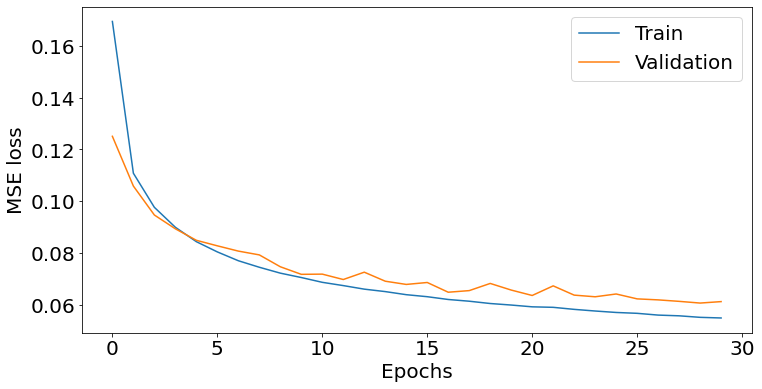

In [ ]:
train_loss = torch.load('/content/drive/My Drive/data_audio/train_loss_lstm2')
val_loss = torch.load('/content/drive/My Drive/data_audio/val_loss_lstm2')


train_loss = (16/17000)*np.array(train_loss)
val_loss = (16/3000)*np.array(val_loss)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (12, 6))
plt.plot(train_loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative evaluation

In [17]:
def evaluate_qualitative(net, audio_dirs, num_example, speech_rate=16000):
  """
  net: LSTM based model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15)  
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  X_test = torch.load(audio_dirs[0])
  y_test = torch.load(audio_dirs[1])
  waves = torch.load(audio_dirs[2])
  waves_target = torch.load(audio_dirs[3])

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  net.eval()

  example_rev = torch.clone(X_test[num_example, :, :, :])
  target = torch.clone(y_test[num_example, :, :, :])

  ex_rev_norm, ex_data_norm = normalize(example_rev[0, :, :].numpy())
  target_norm, target_data_norm = normalize(target[0, :, :].numpy())

  example_rev[0, :, :] = torch.tensor(ex_rev_norm)
  target[0, :, :] = torch.tensor(target_norm)

  spec_test0, targets0 = split_specgram(example_rev, target)
  spec_test_response = net(spec_test0).cpu().detach().numpy().T

  spec_test_response = spec_test_response*(ex_data_norm[1]+1e-6) + ex_data_norm[0]
  spec_test_response = cv2.resize(spec_test_response, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(clean_spec)
  graph_spec(original_spec)
  graph_spec(spec_test_response)

In [8]:
net = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
dir_list = ['/content/drive/My Drive/data_audio/X_test', '/content/drive/My Drive/data_audio/y_test',
            '/content/drive/My Drive/data_audio/waverev', '/content/drive/My Drive/data_audio/wavetarget']

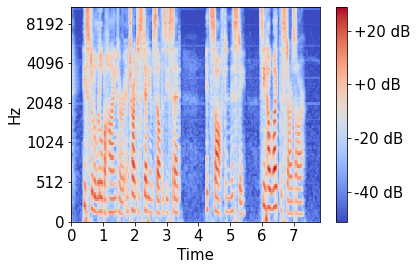

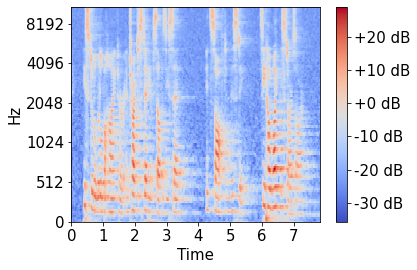

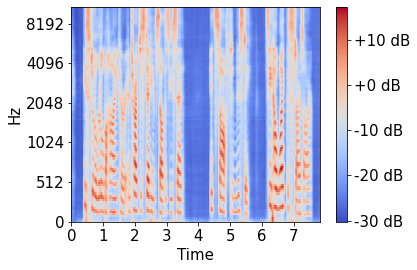

In [14]:
evaluate_qualitative(net, dir_list, 100)

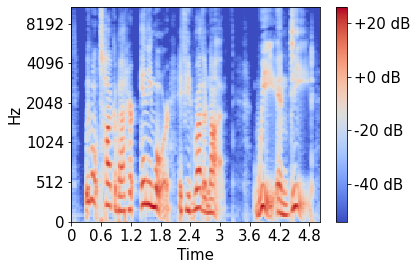

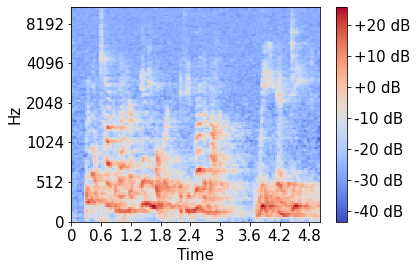

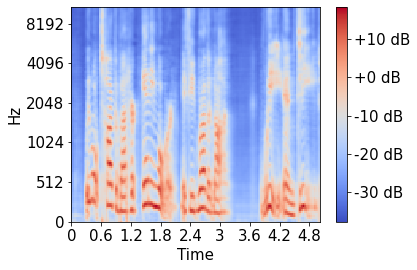

In [15]:
evaluate_qualitative(net, dir_list, 300)

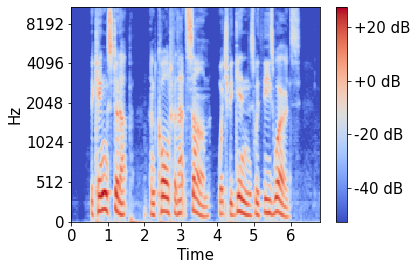

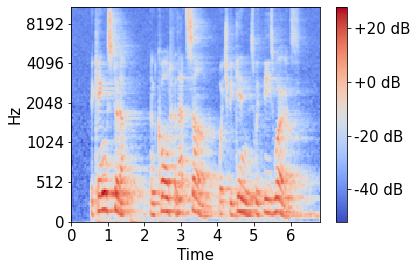

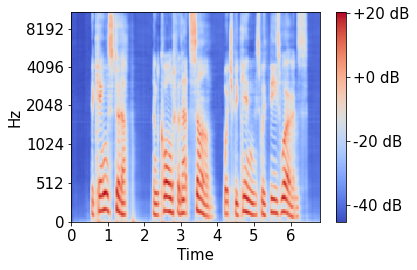

In [16]:
evaluate_qualitative(net, dir_list, 400)


# Quantitative evaluation

Pysepm metrics

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     \ 2.1MB 2.0MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     \ 61kB 38.9MB/s
     \ 307kB 52.3MB/s
     \ 68.3MB 2.3MB/s
     |████████████████████████████████| 163kB 10.7MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp36-none-any.whl size=24291 sha256=d6c2cba8abe380fbce16a46a3a8e1be141c9bfcc4b824dc0888ad8bc1d531d59
  Stored in directory: /tmp/pip-ephem-wheel-cache-z39ib_98/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp36-none-any.whl size=9397 sha256=77ec239ff886fb01af83f346105c3b3342f375bc53c323afc47e6e2172cf553d
  Stored in directory: /tmp/pip-ephem-wheel-cache-z39ib_98/wheels/ef/f1/00/7c2aef84fdfd2c195486371d26b18f72c5bda5fe8442ef4c00
  Created wheel for pesq: filename=pesq-0.0.2-cp36-cp36m-linux_x86_64.whl size=161316 sha256=965d39022e8df2a68dee169ca44280ac9f5f4944220260d00e7cb5329a5132c5

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import *
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp36-cp36m-linux_x86_64.whl size=82984 sha256=e7f11cfe3fcfb24d3c83e8e016f38a957abd6ab6667294acf41cffb978092217
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, dataset, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM based model to evaluate
  dataset: reverb_dataset object to extract examples
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
   
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm')
    reverb_llr_list = torch.load(path + 'reverb_llr_lstm')
    reverb_cd_list = torch.load(path + 'reverb_cd_lstm')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy, target_copy = dataset.__getitem__(i)
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())
      norm_target, norm_stats_target = normalize(target_copy[0, :, :].numpy())
      
      rev_copy_norm = torch.zeros((rev_copy.shape))
      target_copy_norm = torch.zeros((target_copy.shape))
      
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
      target_copy_norm[0, :, :] = torch.tensor(norm_target)
       
      spec_test, targets = split_specgram(rev_copy_norm, target_copy_norm)  
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test, targets = split_specgram(rev_copy[0, :, :].numpy(), target_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    recon_spec = cv2.resize(spec_test_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)

    original = reconstruct_wave(target_copy[0, :, :].numpy())
    reverb = reconstruct_wave(rev_copy[0, :, :].numpy())
    recon = reconstruct_wave(spec_test_response)
    recon_srmr = reconstruct_wave(recon_spec)

    pesq_metric_rev = pesq(original[0:len(reverb)], reverb, fs = speech_rate)
    stoi_metric_rev = stoi(original[0:len(reverb)], reverb, speech_rate)
    llr_metric_rev = llr(original[0:len(reverb)], reverb, speech_rate)
    cd_metric_rev = cepstrum_distance(original[0:len(reverb)], reverb, speech_rate)
    fwSNRseg_metric_rev = fwSNRseg(original[0:len(reverb)], reverb, speech_rate)
    srmr_metric_rev = srmr(waves[i], speech_rate)

    pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
    stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
    llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
    cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
    fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
    srmr_metric_recon = srmr(recon_srmr, speech_rate)

    reverb_pesq_list.append(pesq_metric_rev)
    reverb_stoi_list.append(stoi_metric_rev)
    reverb_llr_list.append(llr_metric_rev)
    reverb_cd_list.append(cd_metric_rev)
    reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
    reverb_srmr_list.append(srmr_metric_rev)

    dereverb_pesq_list.append(pesq_metric_recon)
    dereverb_stoi_list.append(stoi_metric_recon)
    dereverb_llr_list.append(llr_metric_recon)
    dereverb_cd_list.append(cd_metric_recon)
    dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
    print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
    print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
    print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
    print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_lstm')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_lstm')
      torch.save(reverb_llr_list, path + 'reverb_llr_lstm')
      torch.save(reverb_cd_list, path + 'reverb_cd_lstm')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_lstm')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_lstm')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_lstm')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_lstm')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_lstm')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_lstm')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_lstm')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_lstm')
      
      print('Saved')

## Room Simulated 1

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm1')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.162 || PESQ dereverberated signal: 2.354
STOI reverberated signal: 0.802 || STOI dereverberated signal: 0.838
LLR reverberated signal: 0.480 || LLR dereverberated signal: 0.485
CD reverberated signal: 4.051 || CD dereverberated signal: 3.737
fwSNRseg reverberated signal: 8.522 || fwSNRseg dereverberated signal: 9.535
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 3.619


Processing specgram n°:2
PESQ reverberated signal: 2.082 || PESQ dereverberated signal: 2.350
STOI reverberated signal: 0.789 || STOI dereverberated signal: 0.846
LLR reverberated signal: 0.538 || LLR dereverberated signal: 0.572
CD reverberated signal: 4.344 || CD dereverberated signal: 4.115
fwSNRseg reverberated signal: 7.550 || fwSNRseg dereverberated signal: 8.871
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 3.065


Processing specgram n°:3
PESQ reverberated signal: 2.022 || PESQ dereverberated signal: 2.249


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm1')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 172, 500, normalize_data = True, initial = False)

Current device: cpu
Processing specgram n°:173
PESQ reverberated signal: 2.047 || PESQ dereverberated signal: 2.045
STOI reverberated signal: 0.554 || STOI dereverberated signal: 0.650
LLR reverberated signal: 0.521 || LLR dereverberated signal: 0.533
CD reverberated signal: 4.402 || CD dereverberated signal: 3.993
fwSNRseg reverberated signal: 7.049 || fwSNRseg dereverberated signal: 8.886
SRMR reverberated signal: 3.476 || SRMR dereverberated signal: 2.402


Processing specgram n°:174
PESQ reverberated signal: 1.884 || PESQ dereverberated signal: 2.140
STOI reverberated signal: 0.523 || STOI dereverberated signal: 0.582
LLR reverberated signal: 0.743 || LLR dereverberated signal: 0.639
CD reverberated signal: 5.582 || CD dereverberated signal: 4.563
fwSNRseg reverberated signal: 6.337 || fwSNRseg dereverberated signal: 8.513
SRMR reverberated signal: 2.913 || SRMR dereverberated signal: 2.132


Processing specgram n°:175
PESQ reverberated signal: 1.836 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.98
STOI: 0.57
LLR: 0.76
CD: 5.19
fwSNRseg: 7.05
SRMR: 3.17

Dereverberated signal:
PESQ: 2.00
STOI: 0.63
LLR: 0.81
CD: 4.81
fwSNRseg: 7.28
SRMR: 2.89


## Room Simulated 2

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.076 || PESQ dereverberated signal: 1.919
STOI reverberated signal: 0.669 || STOI dereverberated signal: 0.672
LLR reverberated signal: 1.288 || LLR dereverberated signal: 1.290
CD reverberated signal: 6.891 || CD dereverberated signal: 6.639
fwSNRseg reverberated signal: 6.566 || fwSNRseg dereverberated signal: 5.791
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 1.772


Processing specgram n°:2
PESQ reverberated signal: 2.136 || PESQ dereverberated signal: 1.879
STOI reverberated signal: 0.714 || STOI dereverberated signal: 0.724
LLR reverberated signal: 1.261 || LLR dereverberated signal: 1.212
CD reverberated signal: 6.557 || CD dereverberated signal: 6.377
fwSNRseg reverberated signal: 6.310 || fwSNRseg dereverberated signal: 5.440
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 1.654


Processing specgram n°:3
PESQ reverberated signal: 1.989 || PESQ dereverberated signal: 1.984


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.10
STOI: 0.49
LLR: 0.88
CD: 5.39
fwSNRseg: 6.93
SRMR: 4.49

Dereverberated signal:
PESQ: 1.97
STOI: 0.53
LLR: 1.00
CD: 5.49
fwSNRseg: 6.42
SRMR: 2.54


## Room Simulated 3

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 0, 500, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.383 || PESQ dereverberated signal: 2.195
STOI reverberated signal: 0.860 || STOI dereverberated signal: 0.829
LLR reverberated signal: 1.123 || LLR dereverberated signal: 1.171
CD reverberated signal: 6.396 || CD dereverberated signal: 6.360
fwSNRseg reverberated signal: 8.563 || fwSNRseg dereverberated signal: 7.390
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 2.342


Processing specgram n°:2
PESQ reverberated signal: 2.443 || PESQ dereverberated signal: 2.125
STOI reverberated signal: 0.888 || STOI dereverberated signal: 0.855
LLR reverberated signal: 1.119 || LLR dereverberated signal: 1.127
CD reverberated signal: 6.120 || CD dereverberated signal: 6.133
fwSNRseg reverberated signal: 7.822 || fwSNRseg dereverberated signal: 6.517
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 1.938


Processing specgram n°:3
PESQ reverberated signal: 2.266 || PESQ dereverberated signal: 2.274


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 260, 500, normalize_data = True, initial = False)

Current device: cpu
Processing specgram n°:261
PESQ reverberated signal: 2.433 || PESQ dereverberated signal: 2.083
STOI reverberated signal: 0.801 || STOI dereverberated signal: 0.789
LLR reverberated signal: 0.860 || LLR dereverberated signal: 1.064
CD reverberated signal: 5.509 || CD dereverberated signal: 6.308
fwSNRseg reverberated signal: 8.476 || fwSNRseg dereverberated signal: 8.115
SRMR reverberated signal: 2.554 || SRMR dereverberated signal: 1.634


Processing specgram n°:262
PESQ reverberated signal: 2.602 || PESQ dereverberated signal: 2.257
STOI reverberated signal: 0.367 || STOI dereverberated signal: 0.354
LLR reverberated signal: 0.854 || LLR dereverberated signal: 1.008
CD reverberated signal: 5.731 || CD dereverberated signal: 6.285
fwSNRseg reverberated signal: 8.891 || fwSNRseg dereverberated signal: 8.502
SRMR reverberated signal: 2.691 || SRMR dereverberated signal: 1.579


Processing specgram n°:263
PESQ reverberated signal: 2.317 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.32
STOI: 0.64
LLR: 0.78
CD: 5.12
fwSNRseg: 8.64
SRMR: 4.96

Dereverberated signal:
PESQ: 2.15
STOI: 0.65
LLR: 0.97
CD: 5.52
fwSNRseg: 7.58
SRMR: 2.79


## Room Simulated 4

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 0, 250, normalize_data = True, initial = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.198 || PESQ dereverberated signal: 2.303
STOI reverberated signal: 0.747 || STOI dereverberated signal: 0.812
LLR reverberated signal: 0.464 || LLR dereverberated signal: 0.465
CD reverberated signal: 4.101 || CD dereverberated signal: 3.656
fwSNRseg reverberated signal: 7.464 || fwSNRseg dereverberated signal: 8.269
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 4.054


Processing specgram n°:2
PESQ reverberated signal: 2.211 || PESQ dereverberated signal: 2.263
STOI reverberated signal: 0.531 || STOI dereverberated signal: 0.639
LLR reverberated signal: 0.502 || LLR dereverberated signal: 0.355
CD reverberated signal: 4.284 || CD dereverberated signal: 3.198
fwSNRseg reverberated signal: 7.324 || fwSNRseg dereverberated signal: 8.459
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 3.455


Processing specgram n°:3
PESQ reverberated signal: 2.071 || PESQ dereverberated signal: 2.179


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
dataset_test = reverb_dataset(X_test, y_test)

evaluate(model_lstm, dataset_test, path, path_waves, 250, 500, normalize_data = True, initial = False)

Current device: cpu
Processing specgram n°:251
PESQ reverberated signal: 1.881 || PESQ dereverberated signal: 2.030
STOI reverberated signal: 0.530 || STOI dereverberated signal: 0.634
LLR reverberated signal: 0.522 || LLR dereverberated signal: 0.437
CD reverberated signal: 4.508 || CD dereverberated signal: 3.455
fwSNRseg reverberated signal: 5.064 || fwSNRseg dereverberated signal: 7.800
SRMR reverberated signal: 2.539 || SRMR dereverberated signal: 3.913


Processing specgram n°:252
PESQ reverberated signal: 2.022 || PESQ dereverberated signal: 2.242
STOI reverberated signal: 0.805 || STOI dereverberated signal: 0.838
LLR reverberated signal: 0.579 || LLR dereverberated signal: 0.481
CD reverberated signal: 4.873 || CD dereverberated signal: 3.775
fwSNRseg reverberated signal: 5.946 || fwSNRseg dereverberated signal: 8.199
SRMR reverberated signal: 3.222 || SRMR dereverberated signal: 4.162


Processing specgram n°:253
PESQ reverberated signal: 1.815 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_lstm')
reverb_stoi_list = torch.load(path + 'reverb_stoi_lstm')
reverb_llr_list = torch.load(path + 'reverb_llr_lstm')
reverb_cd_list = torch.load(path + 'reverb_cd_lstm')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_lstm')
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_lstm')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_lstm')
dereverb_llr_list = torch.load(path + 'dereverb_llr_lstm')
dereverb_cd_list = torch.load(path + 'dereverb_cd_lstm')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.04
STOI: 0.59
LLR: 0.57
CD: 4.59
fwSNRseg: 6.96
SRMR: 3.15

Dereverberated signal:
PESQ: 2.20
STOI: 0.67
LLR: 0.52
CD: 3.82
fwSNRseg: 8.22
SRMR: 3.89


In [ ]:
def evaluate_realdata(net, X_test, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: LSTM based model to evaluate
  X_test: tensor containing reverberant spectrograms (real data, not simulated)
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
 
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy = X_test[i, :, :, :]
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())      
      rev_copy_norm = torch.zeros((rev_copy.shape))    
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
  
      spec_test = split_realdata(rev_copy_norm) 
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test = split_realdata(rev_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    recon_spec = cv2.resize(spec_test_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
    recon_srmr = reconstruct_wave(recon_spec)

    srmr_metric_rev = srmr(waves[i], speech_rate)
    srmr_metric_recon = srmr(recon_srmr, speech_rate)

    reverb_srmr_list.append(srmr_metric_rev)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path + 'reverb_srmr_lstm')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_lstm')
      
      print('Saved')

## Far real data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
path_waves = '/content/drive/My Drive/real_data/waves2'
#model_dnn = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/real_data/X_test_real2')

evaluate_realdata(model_lstm, X_test, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 6.479


Processing specgram n°:2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 5.143


Processing specgram n°:3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 5.740


Processing specgram n°:4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 5.027


Processing specgram n°:5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 6.325


Processing specgram n°:6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 4.369


Processing specgram n°:7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 6.914


Processing specgram n°:8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 4.879


Processing specgram n°:9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 5.174


Processing specgram n°:10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 7.166


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')

print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 4.36

Dereverberated signal:
SRMR: 5.42


## Near real data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_waves = '/content/drive/My Drive/real_data/waves1'
#model_dnn = torch.load('/content/drive/My Drive/data_audio/model_lstm2')
model_lstm = torch.load('/content/drive/My Drive/data_audio/model_lstm2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/real_data/X_test_real1')

evaluate_realdata(model_lstm, X_test, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 3.084


Processing specgram n°:2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.951


Processing specgram n°:3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.370


Processing specgram n°:4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 2.568


Processing specgram n°:5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 2.836


Processing specgram n°:6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 3.374


Processing specgram n°:7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 4.280


Processing specgram n°:8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 3.871


Processing specgram n°:9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 2.631


Processing specgram n°:10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 4.283


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_lstm')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_lstm')
print('Results: \n')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

SRMR: 3.99

Dereverberated signal:
SRMR: 4.36
